### Setup & Imports

In [2]:
#Imports
from pathlib import Path
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
import warnings
warnings.filterwarnings("ignore")

#Settings
sns.set(style="whitegrid", palette="muted", font_scale=1.1)
plt.rcParams["figure.figsize"] = (8,5)


### Load Dataset

In [4]:
# Define relative path 
DATA_DIR = Path("../data")
file_path = DATA_DIR / "Telco_customer_churn.xlsx"

assert file_path.exists(), f"Dataset not found at {file_path}."

# Load dataset
df = pd.read_excel(file_path)
print("Shape:", df.shape)
df.head()


Shape: (7043, 33)


,CustomerID,Count,Country,State,City,Zip Code,Lat Long,Latitude,Longitude,Gender,...,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Label,Churn Value,Churn Score,CLTV,Churn Reason
0,3668-QPYBK,1,United States,California,Los Angeles,90003,"33.964131, -118.272783",33.964131,-118.272783,Male,...,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,1,86,3239,Competitor made better offer
1,9237-HQITU,1,United States,California,Los Angeles,90005,"34.059281, -118.30742",34.059281,-118.307420,Female,...,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,1,67,2701,Moved
2,9305-CDSKC,1,United States,California,Los Angeles,90006,"34.048013, -118.293953",34.048013,-118.293953,Female,...,Month-to-month,Yes,Electronic check,99.65,820.5,Yes,1,86,5372,Moved
3,7892-POOKP,1,United States,California,Los Angeles,90010,"34.062125, -118.315709",34.062125,-118.315709,Female,...,Month-to-month,Yes,Electronic check,104.80,3046.05,Yes,1,84,5003,Moved
4,0280-XJGEX,1,United States,California,Los Angeles,90015,"34.039224, -118.266293",34.039224,-118.266293,Male,...,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.3,Yes,1,89,5340,Competitor had better devices


### Dataset Info & Missing Values

In [6]:
print("Data types:")
print(df.dtypes)

# Summary stats for numeric columns
display(df.describe().T)

# Missing values check
missing = df.isna().sum()
missing = missing[missing > 0].sort_values(ascending=False)
print("Missing values per column:")
display(missing)


Data types:
CustomerID            object
Count                  int64
Country               object
State                 object
City                  object
Zip Code               int64
Lat Long              object
Latitude             float64
Longitude            float64
Gender                object
Senior Citizen        object
Partner               object
Dependents            object
Tenure Months          int64
Phone Service         object
Multiple Lines        object
Internet Service      object
Online Security       object
Online Backup         object
Device Protection     object
Tech Support          object
Streaming TV          object
Streaming Movies      object
Contract              object
Paperless Billing     object
Payment Method        object
Monthly Charges      float64
Total Charges         object
Churn Label           object
Churn Value            int64
Churn Score            int64
CLTV                   int64
Churn Reason          object
dtype: object


,count,mean,std,min,25%,50%,75%,max
Count,7043.0,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000
Zip Code,7043.0,93521.964646,1865.794555,90001.000000,92102.000000,93552.000000,95351.000000,96161.000000
Latitude,7043.0,36.282441,2.455723,32.555828,34.030915,36.391777,38.224869,41.962127
Longitude,7043.0,-119.798880,2.157889,-124.301372,-121.815412,-119.730885,-118.043237,-114.192901
Tenure Months,7043.0,32.371149,24.559481,0.000000,9.000000,29.000000,55.000000,72.000000
Monthly Charges,7043.0,64.761692,30.090047,18.250000,35.500000,70.350000,89.850000,118.750000
Churn Value,7043.0,0.265370,0.441561,0.000000,0.000000,0.000000,1.000000,1.000000
Churn Score,7043.0,58.699418,21.525131,5.000000,40.000000,61.000000,75.000000,100.000000
CLTV,7043.0,4400.295755,1183.057152,2003.000000,3469.000000,4527.000000,5380.500000,6500.000000


Missing values per column:


Churn Reason    5174
dtype: int64

### Tidy Columns & Create Target

In [8]:
# Clean column names
df.columns = [c.strip().replace(" ", "_") for c in df.columns]

# Create binary target
df["Churn_Value"] = (df["Churn_Label"].str.strip().str.lower() == "yes").astype(int)

# Separate numeric & categorical
num_cols = df.select_dtypes(include=["int64","float64"]).columns.tolist()
cat_cols = df.select_dtypes(include=["object","category","bool"]).columns.tolist()

num_cols = [c for c in num_cols if c != "Churn_Value"]
cat_cols = [c for c in cat_cols if c != "Churn_Label"]

print("Numeric features:", num_cols)
print("Categorical features:", cat_cols)


Numeric features: ['Count', 'Zip_Code', 'Latitude', 'Longitude', 'Tenure_Months', 'Monthly_Charges', 'Churn_Score', 'CLTV']
Categorical features: ['CustomerID', 'Country', 'State', 'City', 'Lat_Long', 'Gender', 'Senior_Citizen', 'Partner', 'Dependents', 'Phone_Service', 'Multiple_Lines', 'Internet_Service', 'Online_Security', 'Online_Backup', 'Device_Protection', 'Tech_Support', 'Streaming_TV', 'Streaming_Movies', 'Contract', 'Paperless_Billing', 'Payment_Method', 'Total_Charges', 'Churn_Reason']


In [9]:
# Convert cols to numeric
for c in ["Total_Charges", "Monthly_Charges", "tenure", "Tenure_Months"]:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

# Fill missing
df[num_cols] = df[num_cols].fillna(df[num_cols].median())
df[cat_cols] = df[cat_cols].fillna("Missing")

print("After cleaning, missing values =", df.isna().sum().sum())


After cleaning, missing values = 0


### Target Distribution

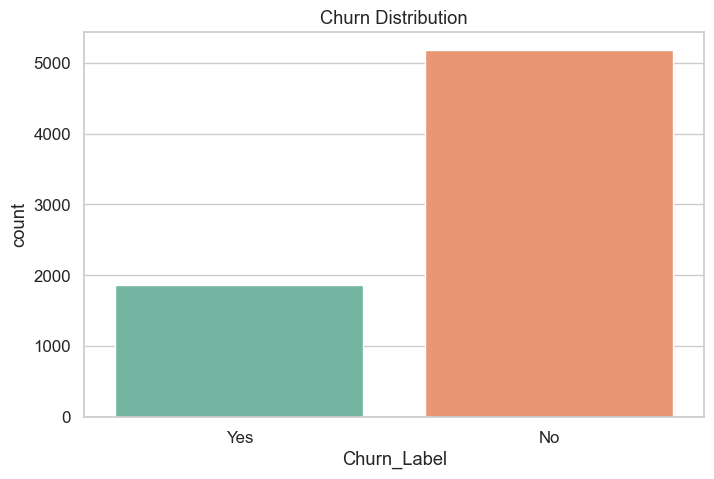

In [11]:
sns.countplot(x="Churn_Label", data=df, palette="Set2")
plt.title("Churn Distribution")
plt.show()

### Numeric Features Analysis

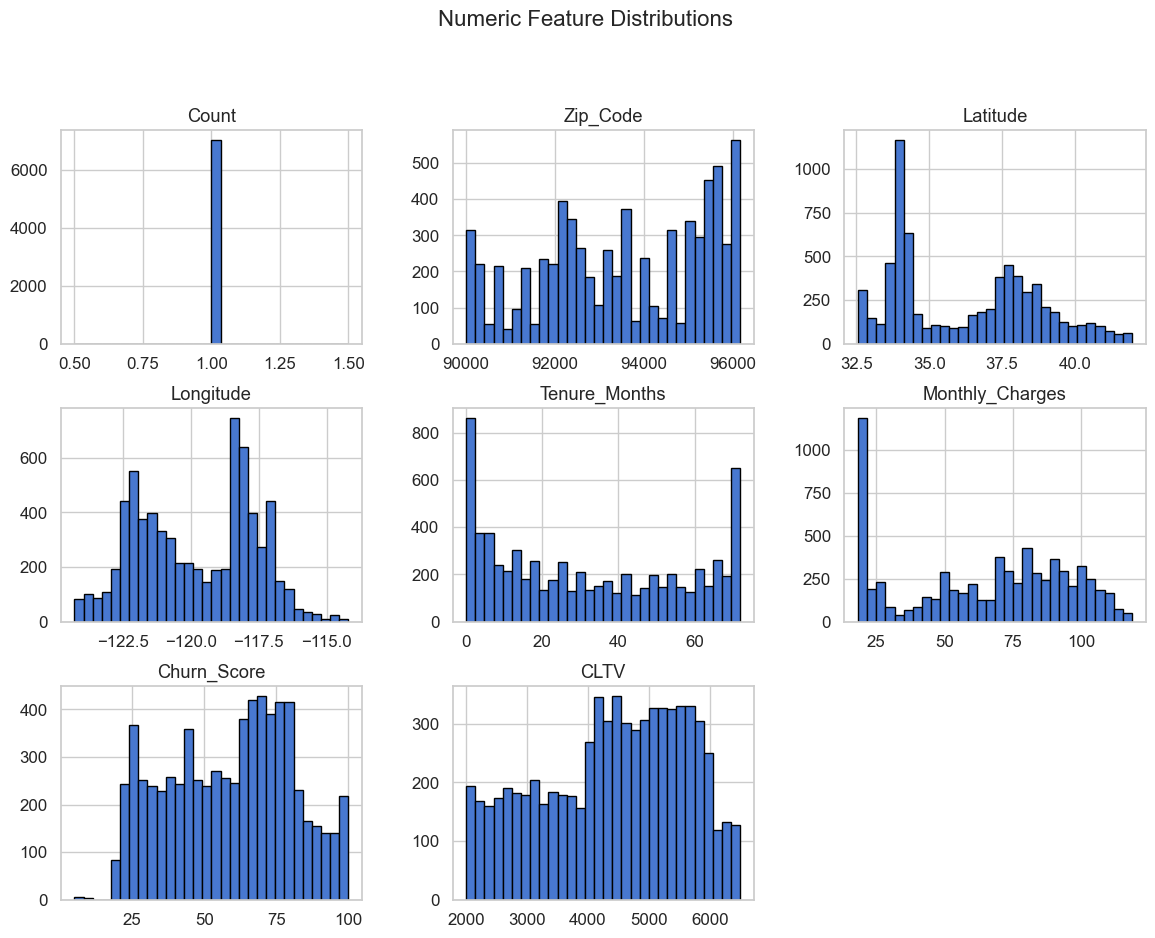

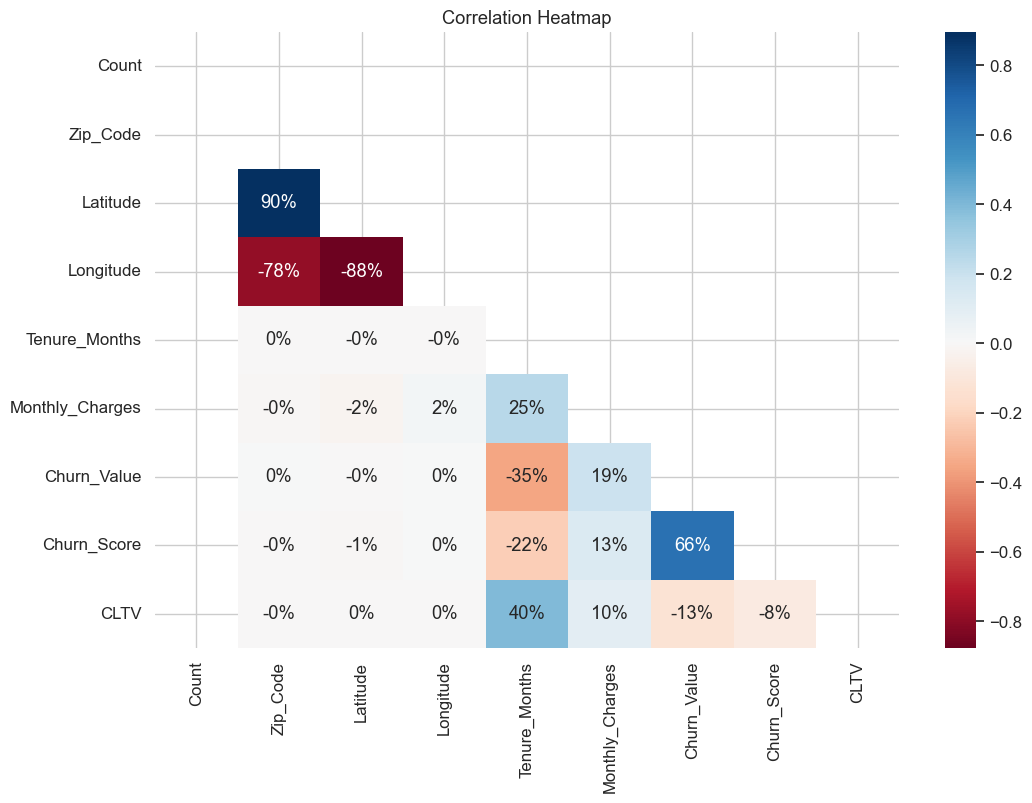

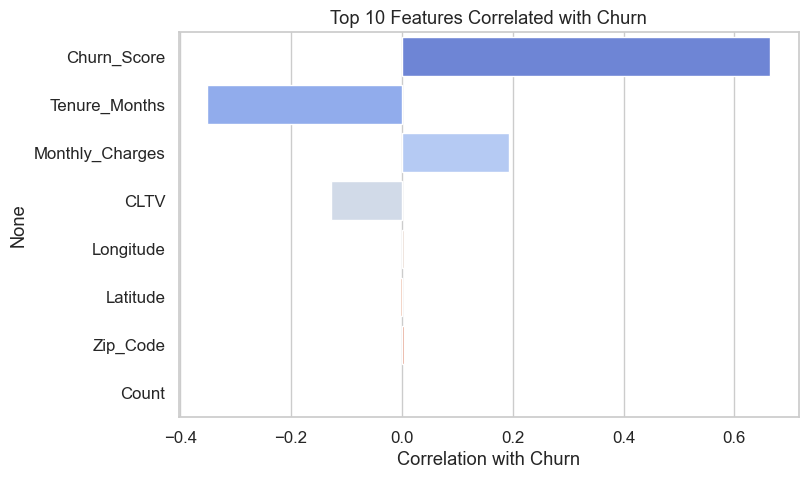

In [13]:
# Histograms
df[num_cols].hist(figsize=(14,10), bins=30, edgecolor="black")
plt.suptitle("Numeric Feature Distributions", y=1.00, fontsize=16)
plt.show()

# Correlation heatmap
plt.figure(figsize=(12,8))
corr = df.corr(numeric_only=True)
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, annot=True, fmt=".0%", cmap="RdBu", center=0)
plt.title("Correlation Heatmap")
plt.show()

# Top correlated features with churn
corr_with_target = df.corr(numeric_only=True)["Churn_Value"].sort_values(key=abs, ascending=False)
top_corr = corr_with_target.drop("Churn_Value").head(10)

plt.figure(figsize=(8,5))
sns.barplot(x=top_corr.values, y=top_corr.index, palette="coolwarm")
plt.title("Top 10 Features Correlated with Churn")
plt.xlabel("Correlation with Churn")
plt.show()


### Categorical Features Analysis

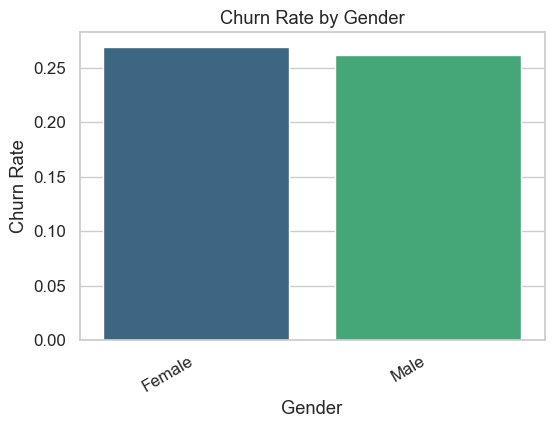

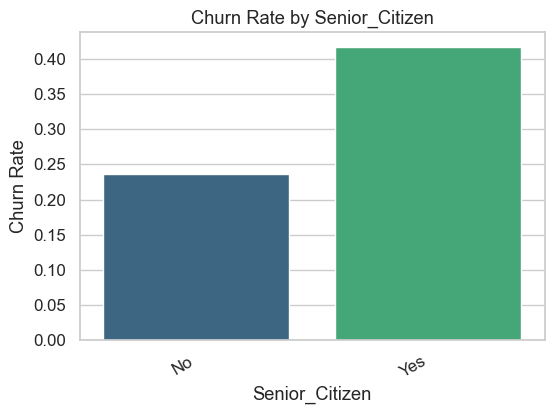

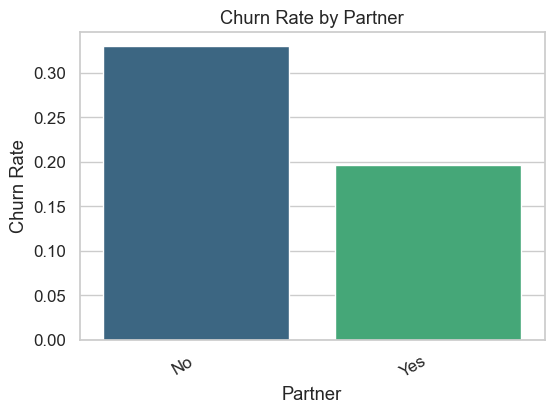

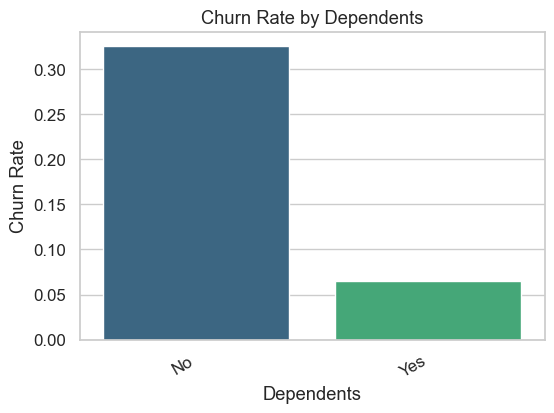

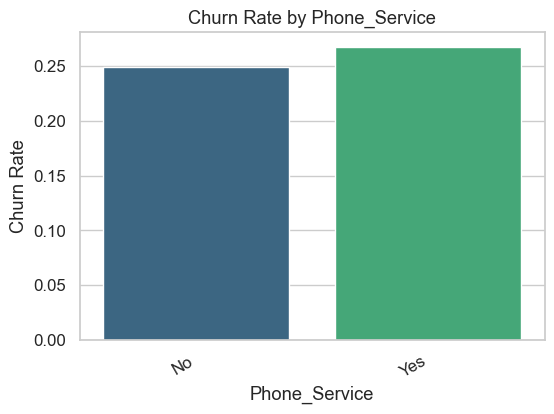

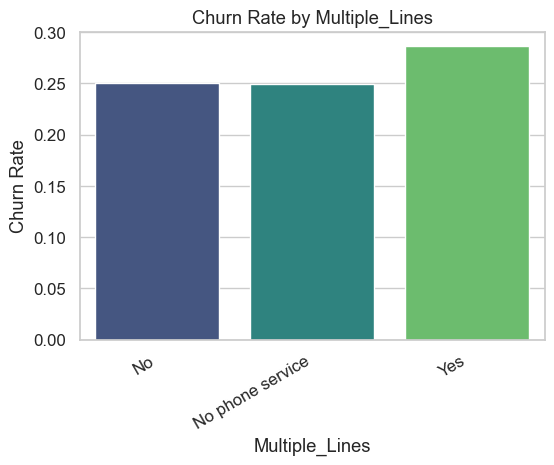

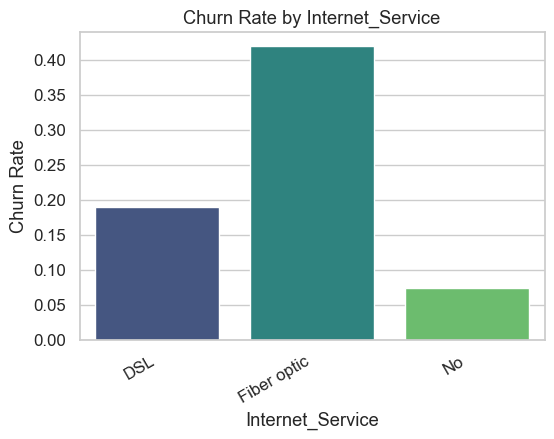

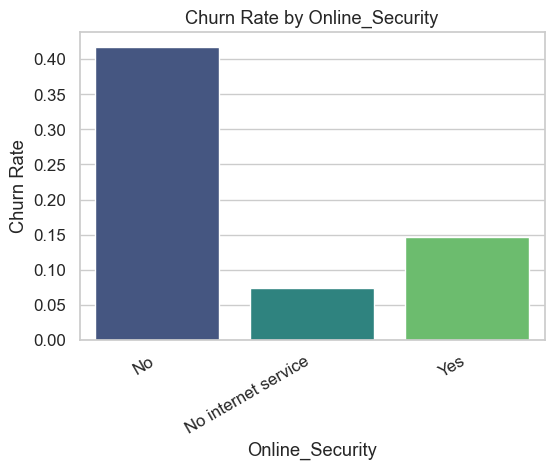

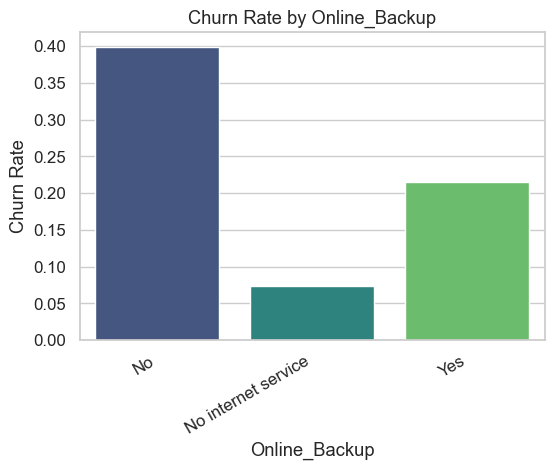

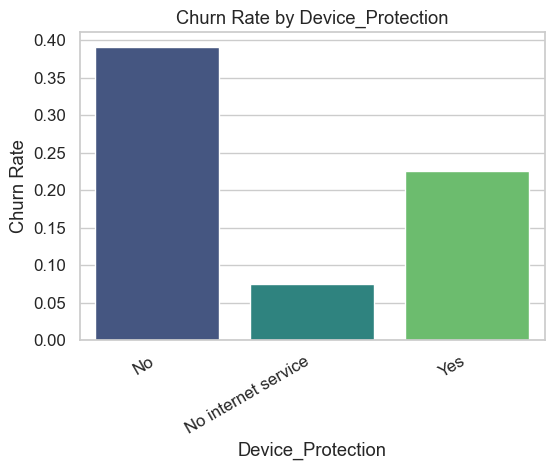

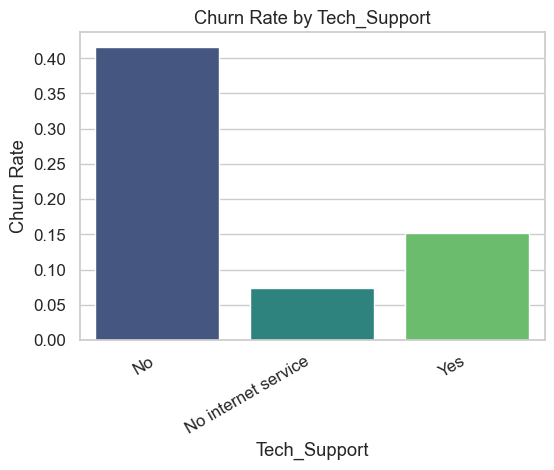

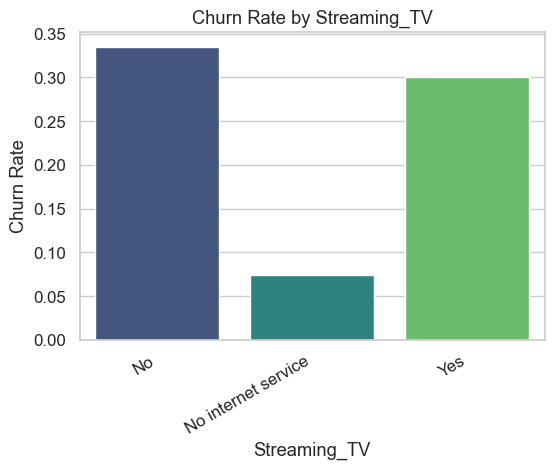

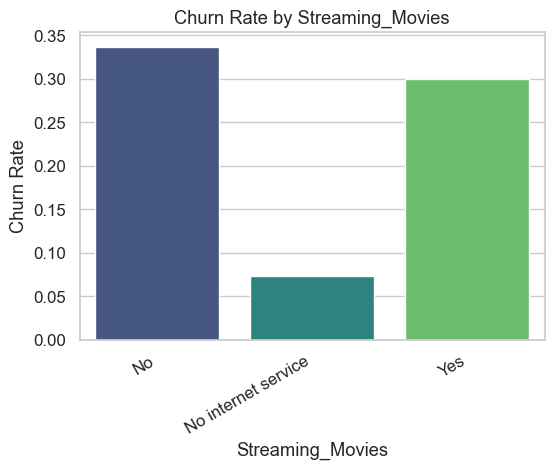

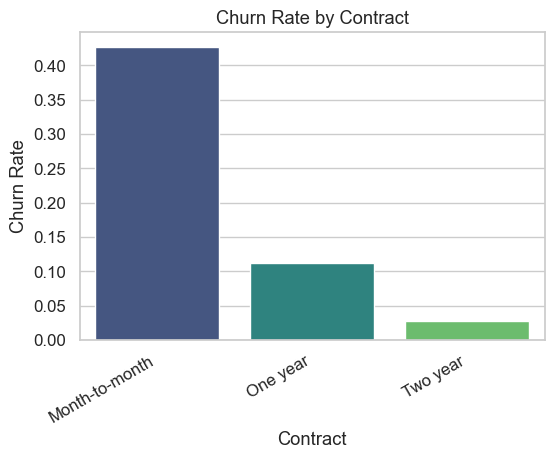

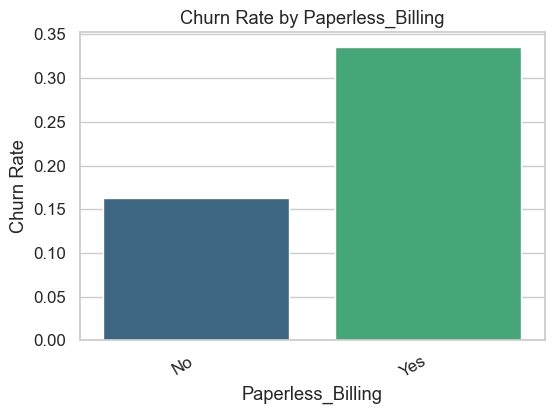

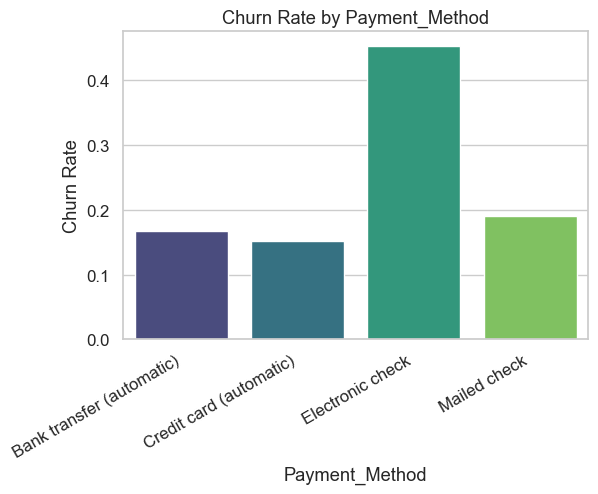

In [15]:
categorical_cols = [
    "Gender", "Senior_Citizen", "Partner", "Dependents",
    "Phone_Service", "Multiple_Lines", "Internet_Service",
    "Online_Security", "Online_Backup", "Device_Protection",
    "Tech_Support", "Streaming_TV", "Streaming_Movies",
    "Contract", "Paperless_Billing", "Payment_Method"
]

for col in categorical_cols:
    if col in df.columns:
        plt.figure(figsize=(6,4))
        churn_rate = df.groupby(col)["Churn_Value"].mean().reset_index()
        sns.barplot(x=col, y="Churn_Value", data=churn_rate, palette="viridis")
        plt.title(f"Churn Rate by {col}")
        plt.xticks(rotation=30, ha="right")
        plt.ylabel("Churn Rate")
        plt.show()


### Statistical Tests (Chi-Square for Categorical)

In [17]:
def chi_square_test(df, feature, target="Churn_Value"):
    contingency = pd.crosstab(df[feature], df[target])
    chi2, p, dof, expected = chi2_contingency(contingency)
    return p

results = [(col, chi_square_test(df, col)) for col in categorical_cols if col in df.columns]
chi_results = pd.DataFrame(results, columns=["Feature","p_value"]).sort_values("p_value")

print("Chi-Square Test Results (categorical features vs churn):")
display(chi_results)

alpha = 0.05
significant_features = chi_results[chi_results["p_value"] < alpha]["Feature"].tolist()
print(f"Significant features at p < {alpha}: {significant_features}")


Chi-Square Test Results (categorical features vs churn):


,Feature,p_value
13,Contract,5.863038e-258
7,Online_Security,2.661150e-185
10,Tech_Support,1.443084e-180
6,Internet_Service,9.571788e-160
15,Payment_Method,3.682355e-140
8,Online_Backup,2.079759e-131
9,Device_Protection,5.505219e-122
3,Dependents,2.500972e-96
12,Streaming_Movies,2.667757e-82
11,Streaming_TV,5.528994e-82


Significant features at p < 0.05: ['Contract', 'Online_Security', 'Tech_Support', 'Internet_Service', 'Payment_Method', 'Online_Backup', 'Device_Protection', 'Dependents', 'Streaming_Movies', 'Streaming_TV', 'Paperless_Billing', 'Senior_Citizen', 'Partner', 'Multiple_Lines']


### EDA Summary
- Dataset has 7043 rows and 33 columns.  
- Churn rate ~ 27% (imbalanced classification problem).  
- Strong churn correlations: Churn Score, Tenure Months, Monthly Charges
- Statistically significant categorical features (p < 0.05): Contract, Tech Support, Internet Support, Payment Method, Online Backup

  
**Next Step | SQL Analysis & Model Prediction**